In [1]:
from __future__ import division
import pylab as plt
from numpy import random,argwhere,linspace,diff,sign
from numpy.random import randint
import numpy as np
%matplotlib inline

In [2]:
tmax = 30
dt = 0.5
nt = int(1 + tmax/dt)

velocities = [-0.5, 0.0, 0.5]
klevels = [0.0,0.3,0.6]
#pp1 = np.array([0.1,0.7,0.2])
#pp2 = np.array([0.25,0.25,0.5])
#theta = random.rand()
#pp = pp1*theta + pp2*(1-theta)
pp = np.array([0.15,0.3,0.55])


def get_P(k):
    # parameter k tunes the hysteresis
    # parameter pp are the columns of P when k=0
    P0 = np.tile(pp,(3,1)).T # matrix when k=0
    P1 = np.eye(3)           # matrix when k=1
    return P0*(1-k)+P1*k 

def update(x,s,P,dt):
    # Draw a new state
    s.append(random.choice(range(3),p=P[:,s[-1]]))
    # Determine new velocity
    v = velocities[s[-1]]
    # Append new position
    x.append(x[-1]+v*dt)

In [3]:
def markov_sim(k,n=1,plots=False):
    """
    k = parameter tuning the hysteresis
    n = number of simulations to run (only last sim is returned)
    """
    P = get_P(k) # state transition matrix
    
    for i in range(n):
        x = [0]          # initial position
        s = [randint(3)] # initial state
        t = 0            # initial time
        while t < tmax:
            t += dt
            update(x,s,P,dt)
        if plots: plt.plot(linspace(0,tmax,len(x)),x)
    
    if plots:
        plt.yticks([-4,6])
        plt.xlabel('time',fontsize=15)
        plt.ylabel('position',fontsize=15)
    return x,s

#     plt.subplot(2,1,2)
#     plt.bar(velocities,np.mean(P,axis=1),width=0.1,align='center')
#     plt.ylim([0,0.6])
#     plt.xticks(velocities)
#     plt.xlim([-0.8,0.8])
#     plt.xlabel('velocity',fontsize=15)
#     plt.ylabel('probability',fontsize=15)

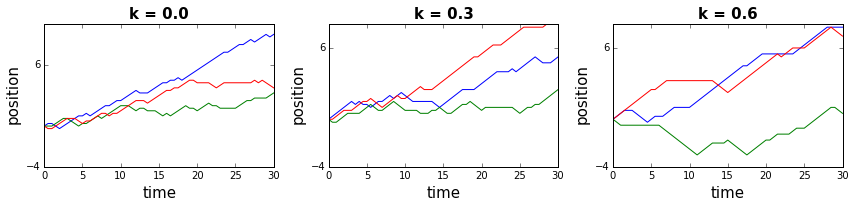

In [4]:
plt.figure(figsize=(12,3))
for splt,k in enumerate(klevels):
    plt.subplot(1,3,splt+1)
    markov_sim(k,n=3,plots=True)
    plt.title('k = '+str(k),fontweight='bold',fontsize=15)
plt.tight_layout()
plt.savefig('panelA.svg')
plt.show()

In [5]:
def sim_ensemble(k,N):
    """ N = number of molecules to simulate """
    X = []
    for i in range(N):
        x,s = markov_sim(k,n=1)
        X.append(x)

    X = np.array(X).T        # each column of X is a trajectory
    t = linspace(0,tmax,len(x))  # time axis
    return t,X

def bin_cable(X,nbins):
    d0,d1 = -25.5,25.5            # ends of the cable
    Bx = np.linspace(d0,d1,nbins) # compartment edges
    dx = Bx[1]-Bx[0]              # compartment size
    Bxc = Bx[:-1]+(dx/2)          # compartment centers
    Cx = np.empty((nt,len(Bxc)))  # concentration in each compartment

    for i in range(len(Bxc)):
        Cx[:,i] = np.mean((X > Bx[i]) & (X <= Bx[i+1]),axis=1)
    
    return Cx,Bxc

def calc_run_lens(X):
    all_runs = []
    for i in range(X.shape[1]):
        xx = list(X[:,i])
        dd = np.cumsum(diff(sign(diff([xx[0]]+xx+[xx[-1]]))))
        runs = [0]
        for d in dd:
            if sign(d) == sign(runs[-1]):
                runs[-1] += d # run length in one dt
            elif d != 0:
                runs.append(d)
        runs.pop(0)
        all_runs += runs
    return np.array(all_runs)*dt*velocities[-1]

def plot_conc_profile(data):
    """ Plot the spatial distribution at several time points"""
    tp = range(0,nt,10)
    cols = np.vstack((np.zeros(len(tp)), np.linspace(0,0.8,len(tp)), np.zeros(len(tp))))
    for (c,i) in enumerate(tp):
        plt.plot(Bxc,data[i,:],'o-',color=cols[:,c],lw=2)
    plt.yticks([0,1])
    plt.ylim([0,1.1])
    plt.xlim([-10,10])
    plt.xlabel('position',fontsize=15)
    plt.ylabel('concentration',fontsize=15)

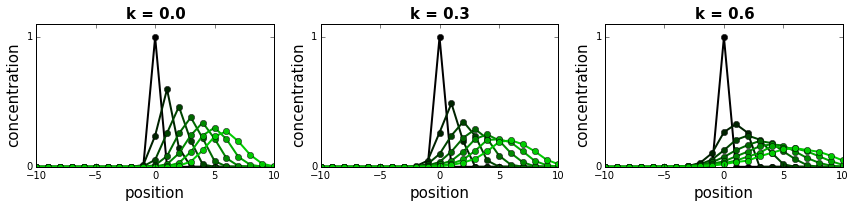

In [6]:
Cx_store = []
X_store = []

plt.figure(figsize=(12,3))
for splt,k in enumerate(klevels):
    plt.subplot(1,3,splt+1)
    t,X = sim_ensemble(k,5000)
    Cx,Bxc = bin_cable(X,52)
    Cx_store.append(Cx)
    X_store.append(X)
    plot_conc_profile(Cx)
    plt.title('k = '+str(k),fontweight='bold',fontsize=15)
plt.tight_layout()
plt.savefig('panelB.svg')
plt.show()

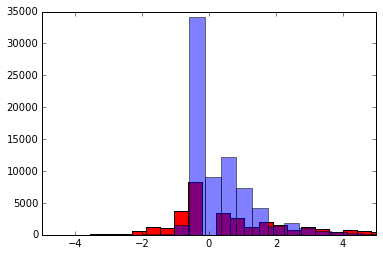

In [7]:
plt.figure()
plt.hist(calc_run_lens(X_store[-1]),50,color='r')
plt.hist(calc_run_lens(X_store[0]),25,color='b',alpha=0.5)
plt.xlim([-5,5])
plt.show()

In [8]:
from scipy.linalg import expm

def mass_action_matrix(a_,b_,nC):
    # transport rate constants
    a = np.ones(nC-1)*a_
    b = np.ones(nC-1)*b_

    # construct state-transistion matrix, A
    mid = np.zeros(nC)
    mid[:-1] -= a
    mid[1:]  -= b
    return np.diag(a, -1) + np.diag(mid) + np.diag(b, 1)

def mass_action_simulate(A,nC):
    # initial condition
    u0 = np.zeros(nC)
    u0[(nC-1)/2] = 1.0
    
    # simulate
    u = [] # trace
    for (i,tt) in enumerate(t):
        u.append(np.dot(expm(A*tt),u0))
    return np.array(u)

def f(x,Ctarg,make_plot=False):
    nC = Ctarg.shape[1]
    A = mass_action_matrix(x[0],x[1],nC)
    u = mass_action_simulate(A,nC)
    
    if make_plot:
        print A
        plt.plot(t,u)
        plt.show()
    
    return np.sum((u-Ctarg)**2)

[ 0.15  0.3   0.55] 



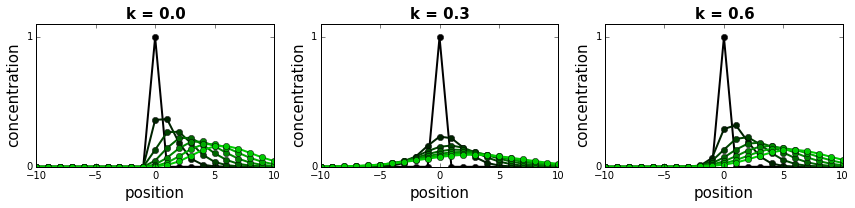

In [9]:
from scipy.optimize import minimize
CxFit_store = []
err_store = []

print pp,'\n'

plt.figure(figsize=(12,3))
for splt,Cx in enumerate(Cx_store):
    plt.subplot(1,3,splt+1)
    sol = minimize(lambda x: f(x,Cx),[0.08,0.35],bounds=[(0,None),(0,None)])
    a_opt,b_opt = sol.x
    err_store.append(sol.fun)
    A = mass_action_matrix(a_opt,b_opt,Cx.shape[1])
    CxFit_store.append(mass_action_simulate(A,Cx.shape[1]))
    plot_conc_profile(CxFit_store[-1])
    plt.title('k = '+str(klevels[splt]),fontweight='bold',fontsize=15)
plt.tight_layout()
plt.savefig('panelC.svg')
plt.show()

[ 0.15  0.3   0.55] 



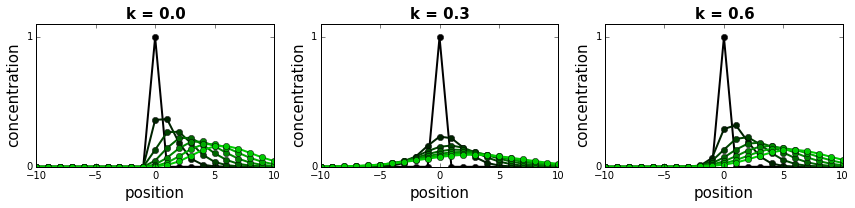

In [10]:
from scipy.optimize import minimize
CxFit_store = []
err_store = []

print pp,'\n'

plt.figure(figsize=(12,3))
for splt,Cx in enumerate(Cx_store):
    plt.subplot(1,3,splt+1)
    sol = minimize(lambda x: f(x,Cx),[0.08,0.35],bounds=[(0,None),(0,None)])
    a_opt,b_opt = sol.x
    err_store.append(sol.fun)
    A = mass_action_matrix(a_opt,b_opt,Cx.shape[1])
    CxFit_store.append(mass_action_simulate(A,Cx.shape[1]))
    plot_conc_profile(CxFit_store[-1])
    plt.title('k = '+str(klevels[splt]),fontweight='bold',fontsize=15)
plt.tight_layout()
plt.savefig('panelC.svg')
plt.show()

In [11]:
err_store

[2.4997120386060363, 5.0420781058401491, 0.37211350113047681]

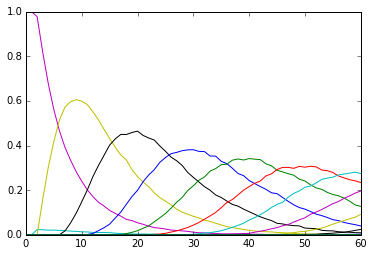

In [15]:
plt.plot(Cx_store[0])
plt.show()

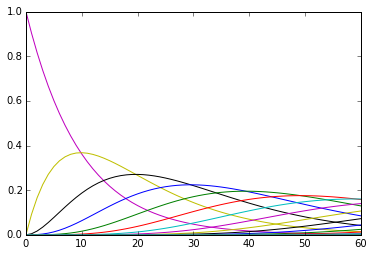

In [16]:
plt.plot(CxFit_store[0])
plt.show()

In [17]:
sol

  status: 0
 success: True
    nfev: 88
     fun: 0.37211350113047681
       x: array([ 0.25681774,  0.0543371 ])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([ -3.66373598e-06,   1.08024700e-05])
     nit: 13